# Pretrained CNN (INC)

In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=24bf4da8f7d43032ca7c7100d9d38c7bf13e74ab09d5908046f534783cd13c5e
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks'

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
import import_ipynb
import os
import tensorflow as tf
import numpy as np
import Utils as utils

from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data preprocessing

In [ ]:
BATCH_SIZE = 16

In [ ]:
#Get datasets
images, labels = utils.load_training()
images, labels = utils.binarize(images, labels, 'mass_calcification')

In [ ]:
images = utils.rescale(images)
images, labels = utils.shuffle_dataset(images, labels)

In [ ]:
images = [np.stack((images[i],)*3, axis=2) for i in range (len(images))]
images = np.array(images)
utils.properties(images)

Properties: 
Shape: (2676, 150, 150, 3)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    )


training_set = data_augmentation.flow(images, labels, seed=123, batch_size=BATCH_SIZE, subset='training')
validation_set = data_augmentation.flow(images, labels, seed=123, batch_size=BATCH_SIZE, subset='validation')

In [ ]:
weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)
weights = dict(enumerate(weights))
print('Class weights: ', weights)

Class weights:  {0: 1.0985221674876848, 1: 0.9176954732510288}


## Training

### Network architecture

In [ ]:
inceptionNet = tf.keras.applications.InceptionV3(
    include_top=False, # if include or not the dense layer (last)
    input_shape=(150,150,3))

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.Model(inputs=inceptionNet.input, outputs=inceptionNet.get_layer('mixed2').output, name="inception"),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')                        
])
model.get_layer("inception").trainable=False
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception (Functional)       (None, 16, 16, 288)       993056    
_________________________________________________________________
flatten_6 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               37749248  
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 38,906,657
Trainable params: 37,913,601
Non-trainable params: 993,056
____________________________________

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     mode='max',
                                     patience=20,
                                     restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('models/inception_mc_16_3.h5',
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)]

                       
history = model.fit(
      training_set,
      epochs=100,
      shuffle=False,
      verbose=1,
      callbacks = callbacks,
      class_weight=weights,
      validation_data=validation_set,
      batch_size=BATCH_SIZE)

Epoch 1/100
134/134 [==============================] - 17s 114ms/step - loss: 1.2539 - accuracy: 0.5808 - val_loss: 0.4658 - val_accuracy: 0.7682
Epoch 2/100
134/134 [==============================] - 15s 115ms/step - loss: 0.4752 - accuracy: 0.7823 - val_loss: 0.3319 - val_accuracy: 0.8617
Epoch 3/100
134/134 [==============================] - 16s 116ms/step - loss: 0.3962 - accuracy: 0.8166 - val_loss: 0.3307 - val_accuracy: 0.8617
Epoch 4/100
134/134 [==============================] - 15s 111ms/step - loss: 0.3724 - accuracy: 0.8418 - val_loss: 0.3943 - val_accuracy: 0.8336
Epoch 5/100
134/134 [==============================] - 15s 110ms/step - loss: 0.3432 - accuracy: 0.8584 - val_loss: 0.2891 - val_accuracy: 0.8748
Epoch 6/100
134/134 [==============================] - 15s 115ms/step - loss: 0.3115 - accuracy: 0.8695 - val_loss: 0.2690 - val_accuracy: 0.8972
Epoch 7/100
134/134 [==============================] - 15s 115ms/step - loss: 0.3198 - accuracy: 0.8777 - val_loss: 0.3595 -

### Training plots

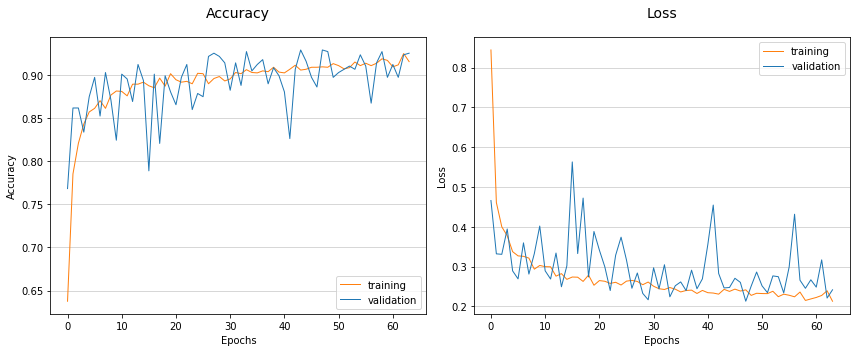

In [ ]:
utils.plot_training(history.history['accuracy'], 
                    history.history['loss'], 
                    history.history['val_accuracy'], 
                    history.history['val_loss'], 
                    64,
                    'figures/inception_mc_16_3.png')

## Evaluation

In [ ]:
test_images, test_labels = utils.load_test()
test_dataset, test_lab = utils.binarize(test_images, test_labels, 'mass_calcification')
test_dataset = utils.rescale(test_dataset)
test_dataset = [np.stack((test_dataset[i],)*3, axis=2) for i in range (len(test_dataset))]

11/11 [==============================] - 1s 20ms/step
Performances: 
Accuracy:  0.9136904761904762
Precision:  0.914225785035172
Recall:  0.9136904761904762
F1-score:  0.9137556258661076
AUC:  0.9142974059708928


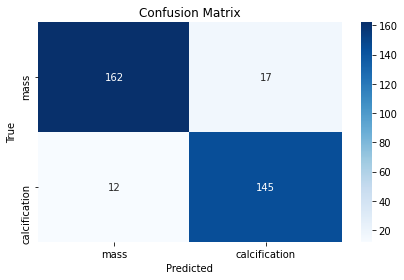

In [ ]:
test_dataset = np.array(test_dataset)
predicted = model.predict(test_dataset, verbose=1)
predicted = [0 if x <=0.5 else 1 for x in predicted]
utils.evaluate_classifier(test_lab, predicted)

utils.plot_confusion_matrix(test_lab, predicted, ['mass', 'calcification'], 'figures/inception_mc_cm_16_3.png')